## Happy Hour Menu Classifier
### Identifying Images of Happy Hour Menus

### Problem Statement:
Existing online restaurant information resources are good at communicating most relevant information to picking a place to eat. However, there is no organized source for information specifically pertaining to happy hour specials. A common way of finding happy hour information within existing resources is finding pictures of happy hour menus sometimes burried in hundreds of images. Machine learning and image processing can be used to expedite the hunt for happy hour.

### Data:
I obtained a dataset of 788 images of happy hour menus and 659 other images representing examples of commonly taken pictures at restaurants. These images were labelled and used to train a CNN. 
Of approximately 1.6 million images of restaurants in San Francisco, I classified a subset of 100,000.

### Project Design

### Data Exploration:

- Typical image histogram shapes involve strong peaks at the upper bound of pixel values corresponding with the white background of menus. Images also have varying degrees of bimodality with another peak in the lower bound of pixel values corresponding with text.
- Example Histograms Below:
![histogram 1](./presentation_figures/58_histograms.png)

![histogram 2](./presentation_figures/460_histograms.png)

![histogram 3](./presentation_figures/170_histograms.png)

![histogram 4](./presentation_figures/617_histograms.png)

### Project Design:
The task of classifying happy hour menus takes place in two steps. The first step is to pass unlabeled images to a convolutional neural network trained to recognize images of menus. The remaining images are then passed to tesseract OCR for text extraction. The resulting text is processed and searched for the phrase "happy hour".

### Data Cleaning Pipeline:
- Grayscale: Images are converted to grayscale as color does not provide meaningful information to my classification task and reduces the complexity of images by a factor of 3
- Standardize Size: All images converted to standardized dimensions of 64 x 48 for twofold reasons. All images must be same dimensions to pass to neural network. Image sized reduced to increase training speed of neural network.
- Pixel values scaled from 0-1
![post process](./presentation_figures/post_process.png)

- To increase size and diversity of training dataset, training images fed through random augmentation pipeline producing additional training examples

In [92]:
import imgaug as ia
from imgaug import augmenters as iaa
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Applies a handful of image transformations to diversify dataset

sometimes = lambda aug: iaa.Sometimes(0.6, aug) #applies given augmenter 50% of the time

seq = iaa.Sequential([
    iaa.Fliplr(0.6),
    iaa.Flipud(0.2), 
    sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,)),
    sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.25, 0.25), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45))), # rotate by -45 to +45 degrees
    sometimes(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))), #sharpen images
    iaa.Invert(0.1) # invert color channels
], random_order=True
)

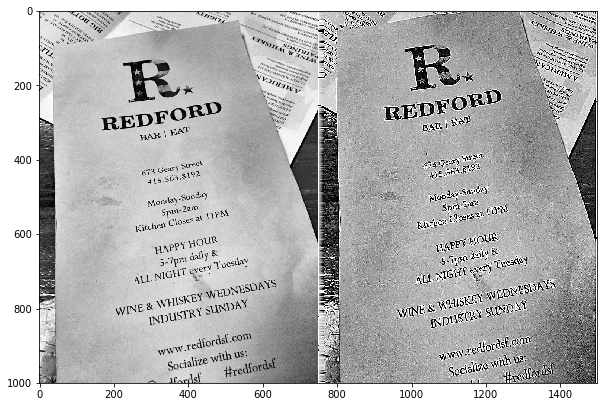

In [110]:
#Test transformation
#Can rerun cell to see random image transformations in effect
image = cv2.imread('./data/test_58.jpg', 0)
image_aug = seq.augment_image(image)
compare = np.hstack((image, image_aug))
plt.figure(figsize=(10,8))
plt.imshow(compare, cmap='gray')

## Neural Network
- Architecture:
    - 3 layers of convolution and max pooling
    - dense layer
    - output layer
    - 85% accuracy on holdout images
    - Of 100,000 test images from 607 restaurants, 19,959 were classified as menus

## Text Comparison Scores
- Classified images are passed to tesseract for string output
- The output strings have some noise in the form of accents and capitalization. Strings are fit to countvectorizer to remove noise and arrange strings into bigrams. 
- The resulting two grams are compared to "happy hour" using Levenshtein.ratio which returns a text similarity score from 0-1. 
- The maximum score from bigrams is stored as the score associated with the image.
- From the subset of 19,959 images, thresholding similarity ratios at 0.78 to remove all false positives results in 15 images containing the phrase happy hour
- Example Results:
![example results](./presentation_figures/example_results.jpg)

### Conclusion:
Multiple sources of loss resulted in very few identified happy hour menus. The causes are likely some combination of the following: CNN image misclassification, and incorrect text detection. 

- It is possible that some bias exists in the dataset I gathered to train the neural network. A possible solution could be to add misclassified test data to the training dataset. The issue could alternatively lie in the architecture of the neural network, although this would not explain the accuracy score I obtained on the holdout data.
- Certain types of images are difficult to extract text from. Images with a certain degree of rotation cannot be processed by tesseract. Additionally, images with varying shades of text have difficulty with the lighter text. This is likely a result of the binarization process that tesseract performs in its internal pipeline. Since otsu's binarization is used, the process is optimal for bimodal images. When lighter text is present on the page, it can potentially fall beyond the calculated threshold for pixel value of one resulting in the text disappearing.

### Next Steps:
To rectify the issue of image rotation, I utilized a processing pipeline to detect edges in the image.
1. Gaussian blurring is performed. This smooths the image and reduces noise.
2. Canny edge detection finds edges in the image. Canny edge detection is a multiple step algorithm involving sobel filtration to find intensity gradients in the image, non-maximum suppression to thin edges, double thresholding to mark edge pixels as strong or weak and suppress those pixels below the weak threshold, and edge tracking by hysteresis in which weak pixels are kept or suppressed based on their connectivity with strong pixels.
3. Dilation after edge detection which passes a kernel across the image and returns 1 for all values underneath the kernel if any pixel underneath the kernel is 1. This effectively closes gaps in edges found by canny edge detection.
4. Hough line transform of the resulting image finds lines. All possible polar coordinate equations for lines passing through a point are mapped. This process is repeated for all points in the image. A place where the mappings overlap represents an equation for a line that passes through multiple points. The algorithm is tuned to have a threshold number of points that must share a common line for that line to be found in the image.
5. The resulting lines correspond with the edges of a menu. These lines are used to calculate degrees of rotation and appropriate cropping boundaries.

## Additional Image Processing

![canny edge](./presentation_figures/canny_edge.png)

![dilation](./presentation_figures/dilation.png)

![dilation](./presentation_figures/lines_only.png)

![hough lines](./presentation_figures/hough_lines.png)

Below is an example of an image cropped with hough line transform. The resulting histogram has much less noise and is more appropriate for Otsu's binarization (an image binarization technique with adaptive thresholding designed for bimodal images).
![cropped histogram](./presentation_figures/cropped_histogram.png)

After Otsu's binarization:
![otsu](./presentation_figures/170_otsu.png)